# Challenge: Build your own NLP model

For this challenge, you will need to choose a corpus of data from nltk or another source that includes categories you can predict and create an analysis pipeline that includes the following steps:

1. Data cleaning / processing / language parsing
2. Create features using two different NLP methods: For example, BoW vs tf-idf.
3. Use the features to fit supervised learning models for each feature set to predict the category outcomes.
4. Assess your models using cross-validation and determine whether one model performed better.
5. Pick one of the models and try to increase accuracy by at least 5 percentage points.

Write up your report in a Jupyter notebook. Be sure to explicitly justify the choices you make throughout, and submit it below.

# Data cleaning / processing / language parsing
For this challenge, we will use the King James Bible from NLTK's gutenberg corpora.

In [145]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from collections import Counter
from sklearn import ensemble
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import scikitplot.plotters as skplt

stopwords = stopwords.words('english')

#nltk.download('product_reviews_1')
#nltk.download('product_reviews_2')
#!python -m spacy download en

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Seaborn version:', sns.__version__)

Numpy version: 1.16.4
Pandas version: 0.23.4
Seaborn version: 0.9.0


In [146]:
df = pd.read_csv('datasets/spooky-author-identification/train.csv', skiprows=1, names=['ID', 'Text', 'Author'])
df.head()

,ID,Text,Author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [147]:
df.describe()

,ID,Text,Author
count,19579,19579,19579
unique,19579,19579,3
top,id12647,"Though I knew that death was near, my curiosit...",EAP
freq,1,1,7900


In [148]:
df.iloc[[0]]['Text']

0    This process, however, afforded me no means of...
Name: Text, dtype: object

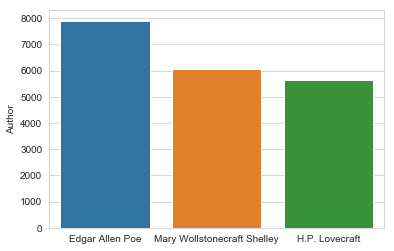

In [149]:
# Barplot of occurances of each author in the training dataset
sns.set_style("whitegrid")
sns.barplot(x=['Edgar Allen Poe', 'Mary Wollstonecraft Shelley', 'H.P. Lovecraft'], y=df['Author'].value_counts())
plt.show()

In [150]:
nlp = spacy.load('en')

In [151]:
# Clean text before feeding it to spaCy
punctuations = string.punctuation

# Define function to cleanup each sentence by removing personal pronouns, stopwords, and puncuation
def cleanup_text(sentences, logging=False):
    sents = []
    counter = 1
    for sent in sentences:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d sentences." % (counter, len(sentences)))
        sent = nlp(sent, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in sent if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        sents.append(tokens)
        counter += 1
    return pd.Series(sents)

In [152]:
# Grab all text associated with Edgar Allen Poe
eap_text = [sent for sent in df[df['Author'] == 'EAP']['Text']]

# Grab all text associated with H.P. Lovecraft
hpl_text = [sent for sent in df[df['Author'] == 'HPL']['Text']]

# Grab all text associated with Mary Wollstonecraft Shelley
mws_text = [sent for sent in df[df['Author'] == 'MWS']['Text']]

# Clean up all text
eap_clean = cleanup_text(eap_text)
eap_clean = ' '.join(eap_clean).split()
# 's appears a lot in the text, so we get rid of it since it's not a word
eap_clean = [word for word in eap_clean if word != '\'s']

hpl_clean = cleanup_text(hpl_text)
hpl_clean = ' '.join(hpl_clean).split()
# 's appears a lot in the text, so we get rid of it since it's not a word
hpl_clean = [word for word in hpl_clean if word != '\'s']

mws_clean = cleanup_text(mws_text)
mws_clean = ' '.join(mws_clean).split()
# 's appears a lot in the text, so we get rid of it since it's not a word
mws_clean = [word for word in mws_clean if word != '\'s']

# Count all unique words
eap_counts = Counter(eap_clean)
hpl_counts = Counter(hpl_clean)
mws_counts = Counter(mws_clean)

print(eap_counts[0])
print(hpl_counts[0])
print(mws_counts[0])

0
0
0


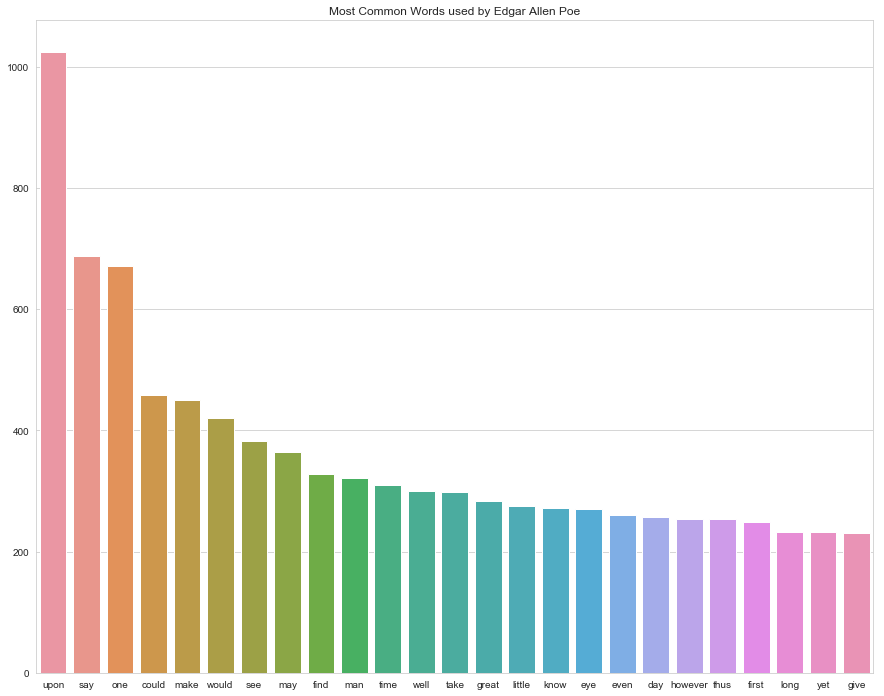

In [153]:
# Plot top 25 most frequently occuring words for Edgar Allen Poe
eap_common_words = [word[0] for word in eap_counts.most_common(25)]
eap_common_counts = [word[1] for word in eap_counts.most_common(25)]

# Use white background
sns.set_style("whitegrid")
plt.figure(figsize=(15, 12))

sns.barplot(x=eap_common_words, y=eap_common_counts)
plt.title('Most Common Words used by Edgar Allen Poe')
plt.show()

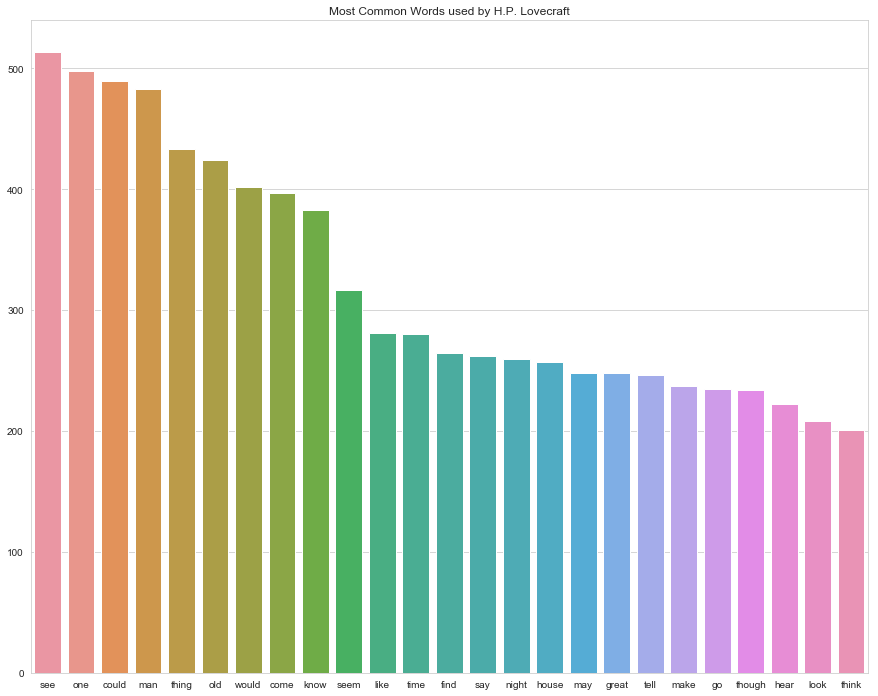

In [154]:
# Plot top 25 most frequently occuring words for H.P. Lovecraft
hpl_common_words = [word[0] for word in hpl_counts.most_common(25)]
hpl_common_counts = [word[1] for word in hpl_counts.most_common(25)]

plt.figure(figsize=(15, 12))
sns.barplot(x=hpl_common_words, y=hpl_common_counts)
plt.title('Most Common Words used by H.P. Lovecraft')
plt.show()

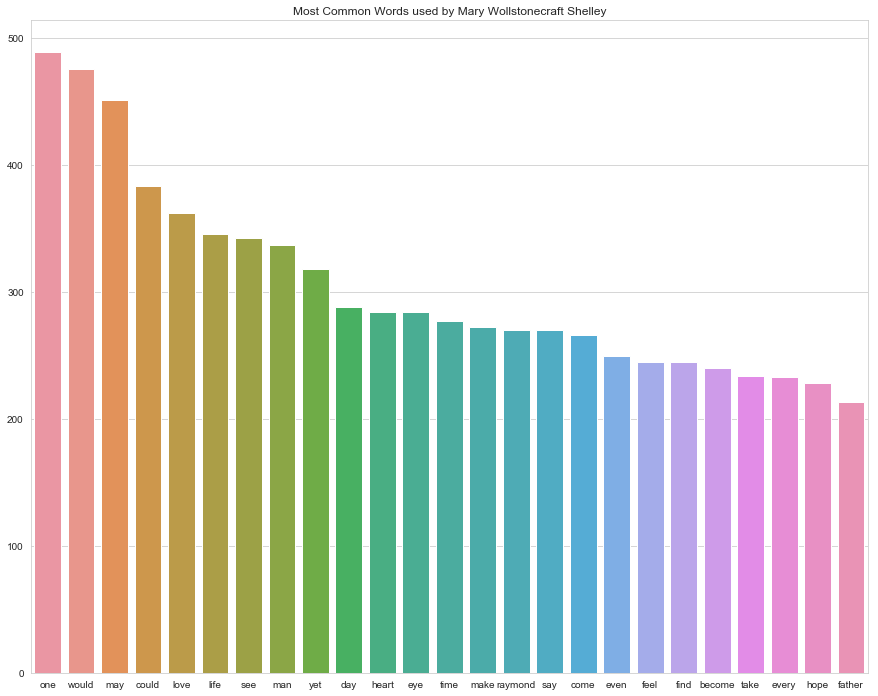

In [155]:
# Plot top 25 most frequently occuring words for Mary Wollstonecraft Shelley
mws_common_words = [word[0] for word in mws_counts.most_common(25)]
mws_common_counts = [word[1] for word in mws_counts.most_common(25)]

plt.figure(figsize=(15, 12))
sns.barplot(x=mws_common_words, y=mws_common_counts)
plt.title('Most Common Words used by Mary Wollstonecraft Shelley')
plt.show()

In [156]:
# Cleanup text and make sure it retains original shape
print('Original training data shape: ', df['Text'].shape)
df_cleaned = cleanup_text(df['Text'], logging=True)
print('Cleaned up training data shape: ', df_cleaned.shape)
df_cleaned = pd.concat([pd.DataFrame(df_cleaned, columns=['Text']), df['Author']], axis=1, ignore_index=True)

Original training data shape:  (19579,)
Processed 1000 out of 19579 sentences.
Processed 2000 out of 19579 sentences.
Processed 3000 out of 19579 sentences.
Processed 4000 out of 19579 sentences.
Processed 5000 out of 19579 sentences.
Processed 6000 out of 19579 sentences.
Processed 7000 out of 19579 sentences.
Processed 8000 out of 19579 sentences.
Processed 9000 out of 19579 sentences.
Processed 10000 out of 19579 sentences.
Processed 11000 out of 19579 sentences.
Processed 12000 out of 19579 sentences.
Processed 13000 out of 19579 sentences.
Processed 14000 out of 19579 sentences.
Processed 15000 out of 19579 sentences.
Processed 16000 out of 19579 sentences.
Processed 17000 out of 19579 sentences.
Processed 18000 out of 19579 sentences.
Processed 19000 out of 19579 sentences.
Cleaned up training data shape:  (19579,)


In [157]:
df_cleaned.columns = ['Text', 'Author']
df_cleaned.head()

,Text,Author
0,process however afford means ascertain dimensi...,EAP
1,never occur fumbling may mere mistake,HPL
2,left hand gold snuff box caper hill cut manner...,EAP
3,lovely spring look windsor terrace sixteen fer...,MWS
4,find nothing else even gold superintendent aba...,HPL


# Create features using two different NLP methods: For example, BoW vs tf-idf.

In [158]:
df_cleaned.Text

0        process however afford means ascertain dimensi...
1                    never occur fumbling may mere mistake
2        left hand gold snuff box caper hill cut manner...
3        lovely spring look windsor terrace sixteen fer...
4        find nothing else even gold superintendent aba...
5        youth pass solitude good year spend gentle fem...
6        astronomer perhaps point take refuge suggestio...
7                               surcingle hang riband body
8        know could say stereotomy without bring think ...
9        confes neither structure language code governm...
10       shall find feel injury shall learn dread reven...
11                                barricade present secure
12       herbert west need fresh body life work reanima...
13       farm like ground extend back deeply hill almos...
14                                glance show fallacy idea
15       escape must commence destructive almost endles...
16       speech give course interpretation fancy doubt .

In [159]:
X = df['Text']
y = df['Author']
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## BoW with CountVectorizer

In [161]:
vect = CountVectorizer(lowercase=False, token_pattern=r'\w+|\,')
X_cv=vect.fit_transform(X)
X_train_cv = vect.transform(X_train)
X_test_cv = vect.transform(X_test)
print(X_train_cv.shape)

(14684, 27497)


# Tf-idf

In [162]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  
                      max_features=None, 
                      strip_accents='unicode', 
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
X_tfv = tfv.fit_transform(list(X_train) + list(X_test))
X_train_tfv =  tfv.transform(X_train) 
X_test_tfv = tfv.transform(X_test)
print(X_train_tfv.shape)

(14684, 15102)


# Use the features to fit supervised learning models for each feature set to predict the category outcomes.

## BoW with CountVectorizer
### Random Forest Classifier

In [163]:
rfc = RandomForestClassifier()
train = rfc.fit(X_train_cv, y_train)
print('Training set score:', rfc.score(X_train_cv, y_train))
print('\nTest set score:', rfc.score(X_test_cv, y_test))

/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training set score: 0.9867202397166984

Test set score: 0.6151174668028601


### Logistic Regression

In [164]:
lr = LogisticRegression(C=1.0) # No need to specify l2 as it's the default. But we put it for demonstration.
train = lr.fit(X_train_cv, y_train)
print(X_train_cv.shape, y_train.shape)
print('Training set score:', lr.score(X_train_cv, y_train))
print('\nTest set score:', lr.score(X_test_cv, y_test))

/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


(14684, 27497) (14684,)
Training set score: 0.9765050394987742

Test set score: 0.8269662921348314


### Gradient Boosting Classifier

In [165]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train_cv, y_train)

print('Training set score:', clf.score(X_train_cv, y_train))
print('\nTest set score:', clf.score(X_test_cv, y_test))

Training set score: 0.7031462816671207

Test set score: 0.6776302349336057


## Tf-idf
### Random Forest Classifier

In [166]:
train = rfc.fit(X_train_tfv, y_train)

print('Training set score:', rfc.score(X_train_tfv, y_train))
print('\nTest set score:', rfc.score(X_test_tfv, y_test))

Training set score: 0.9863797330427676

Test set score: 0.6686414708886619


### Logistic Regression

In [167]:
train = lr.fit(X_train_tfv, y_train)
print(X_train_tfv.shape, y_train.shape)
print('Training set score:', lr.score(X_train_tfv, y_train))
print('\nTest set score:', lr.score(X_test_tfv, y_test))

/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


(14684, 15102) (14684,)
Training set score: 0.9054753473168075

Test set score: 0.7948927477017365


### Gradient Boosting Classifier

In [168]:
train = clf.fit(X_train_tfv, y_train)

print('Training set score:', clf.score(X_train_tfv, y_train))
print('\nTest set score:', clf.score(X_test_tfv, y_test))

Training set score: 0.6402887496594933

Test set score: 0.5948927477017365


# Assess your models using cross-validation and determine whether one model performed better.

## BoW with CountVectorizer
### Random Forest Classifier

In [169]:
scores_cv_rfc = cross_val_score(rfc, X_cv, y, cv=10)
print('Cross Validation Accuracy Scores:', scores_cv_rfc)
print('Average Cross Validation Accuracy:', scores_cv_rfc.mean())

Cross Validation Accuracy Scores: [0.62378765 0.63195508 0.61051557 0.62276672 0.6174668  0.61522739
 0.60858457 0.63924374 0.64537557 0.61982626]
Average Cross Validation Accuracy: 0.6234749352668174


### Logistic Regression

In [170]:
scores_cv_lr = cross_val_score(lr, X_cv, y, cv=10)
print('Cross Validation Accuracy Scores:', scores_cv_lr)
print('Average Cross Validation Accuracy:', scores_cv_lr.mean())

/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Cross Validation Accuracy Scores: [0.8402246  0.82950485 0.82491067 0.8330781  0.84167518 0.82830864
 0.8334185  0.82779765 0.84312724 0.83188554]
Average Cross Validation Accuracy: 0.833393095982324


### Gradient Boosting Classifier

In [171]:
scores_tfv_clf = cross_val_score(clf, X_tfv, y, cv=10)
print('Cross Validation Accuracy Scores:', scores_tfv_clf)
print('Average Cross Validation Accuracy:', scores_tfv_clf.mean())

Cross Validation Accuracy Scores: [0.39561001 0.39663093 0.39509954 0.40020419 0.3988764  0.40112417
 0.39550332 0.407256   0.40265713 0.39550332]
Average Cross Validation Accuracy: 0.398846501495361


## Tf-idf
### Random Forest Classifier

In [172]:
scores_tfv_rfc = cross_val_score(rfc, X_tfv, y, cv=10)
print('Cross Validation Accuracy Scores:', scores_tfv_rfc)
print('Average Cross Validation Accuracy:', scores_tfv_rfc.mean())

Cross Validation Accuracy Scores: [0.36702399 0.36498213 0.37570189 0.36906585 0.36363636 0.36228922
 0.34287174 0.36177823 0.37506387 0.37148697]
Average Cross Validation Accuracy: 0.3653900263621835


### Logistic Regression

In [173]:
scores_tfv_lr = cross_val_score(lr, X_tfv, y, cv=10)
print('Cross Validation Accuracy Scores:', scores_tfv_lr)
print('Average Cross Validation Accuracy:', scores_tfv_lr.mean())

/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Cross Validation Accuracy Scores: [0.36498213 0.37161817 0.37212864 0.37876468 0.38100102 0.37608585
 0.36995401 0.36382218 0.38068472 0.3592233 ]
Average Cross Validation Accuracy: 0.3718264696852408


### Gradient Boosting Classifier

In [174]:
scores_tfv_clf = cross_val_score(clf, X_tfv, y, cv=10)
print('Cross Validation Accuracy Scores:', scores_tfv_clf)
print('Average Cross Validation Accuracy:', scores_tfv_clf.mean())

Cross Validation Accuracy Scores: [0.3971414  0.40224604 0.39356815 0.40173558 0.39836568 0.4036791
 0.39856924 0.40827798 0.40061318 0.39703628]
Average Cross Validation Accuracy: 0.40012326274822724


Logistic Regression with CountVectorizer turned out to be the best model, by far. There was a severe performance degradation using the Tf-idf method to create features, so clearly using Bag of Words method via CountVectorizer was a far superior method. We will stick to that for any pending analysis.

# Pick one of the models and try to increase accuracy by at least 5 percentage points.

In [175]:
# Transform labels into one hot encoded format.
#y = df['Author']
#y_ohe = label_binarize(y, classes=['EAP', 'HPL', 'MWS'])
#print('y_ohe shape: {}'.format(y_ohe.shape))
#print('y_ohe samples:')
#print(y_ohe[:5])

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## BoW with CountVectorizer

In [177]:
vect = CountVectorizer(lowercase=False, token_pattern=r'\b[^\d\W]+\b')
X_cv=vect.fit_transform(X)
X_train_cv = vect.transform(X_train)
X_test_cv = vect.transform(X_test)
print(X_train_cv.shape)

(14684, 27496)


## Logistic Regression

/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished
/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 0.4665555029044601
Accuracy: 0.8200623116604525


/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


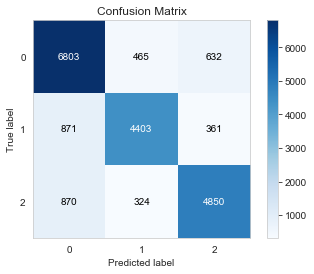

In [178]:
probas = cross_val_predict(lr, X_cv, y, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
pred_indices = np.argmax(probas, axis=1)
classes = np.unique(y)
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(y, probas)))
print('Accuracy: {}'.format(accuracy_score(y, preds)))
skplt.plot_confusion_matrix(y, preds)

In [179]:
lr = LogisticRegression(C=1.0) # No need to specify l2 as it's the default. But we put it for demonstration.
train = lr.fit(X_train_cv, y_train)
print(X_train_cv.shape, y_train.shape)
print('Training set score:', lr.score(X_train_cv, y_train))
print('\nTest set score:', lr.score(X_test_cv, y_test))

/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


(14684, 27496) (14684,)
Training set score: 0.9765731408335603

Test set score: 0.822267620020429


In [180]:
scores_cv_lr = cross_val_score(lr, X_cv, y, cv=10)
print('Cross Validation Accuracy Scores:', scores_cv_lr)
print('Average Cross Validation Accuracy:', scores_cv_lr.mean())

/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rakeshbhatia/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Cross Validation Accuracy Scores: [0.83460949 0.83256764 0.82644206 0.83256764 0.84269663 0.82268779
 0.83495146 0.82473173 0.84414921 0.83392948]
Average Cross Validation Accuracy: 0.8329333127087765


In [181]:
#analyzer = 'char'